https://www.kaggle.com/code/nageshsingh/build-knowledge-graph-using-python/notebook

## 1. Import packages

In [3]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
from spacy.lang.en.examples import sentences 

#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


In [5]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("data-jobs-20221123.csv")
candidate_sentences.shape

candidate_sentences

,job_title,role,description
0,Identity and Access Management Administrator,administrator,"Job Summary\nThe Identity and Access Management Administrator shall be responsible for:\nPerforming systems management activities for current and future computer systems, related hardware, softwar..."
1,Systems Administrator (Hybrid Remote),administrator,"Systems Administrator (Hybrid Remote)\n\nChristar is an interdenominational mission organization based in Richardson, TX. Our goal is to proclaim the Gospel and establish churches within the least..."
2,IT Administrator/Helpdesk,administrator,"IT Administrator/Helpdesk\nIf you are a IT Administrator with at least two years of experience, please read on!\n\nBased in the heart of Silicon Valley we are a unified communications company that..."
3,IT Administrator/Helpdesk L2/L3,administrator,"IT Administrator/Helpdesk L2/L3\nIf you are a IT Administrator with at least two years of experience, please read on!\n\nBased in the heart of Silicon Valley we are a unified communications compan..."
4,Identity Access Management AD Systems Administrator,administrator,Deloitte Global is the engine of the Deloitte network. Our professionals reach across disciplines and borders to develop and lead global initiatives. We deliver strategic programs and services tha...
...,...,...,...
448,Senior Identity Access Management Specialist,specialist,Sr Info Sec Ops Specialist\nThe Senior Information Security Operations Specialist primary function is to drive the direction of our IAM program to ensure applications and platforms within the TIAA...
449,Database Management Specialist - Oracle 19c (Remote),specialist,"Secure our Nation, Ignite your Future\n\nBecome an integral part of a diverse team while working at an Industry Leading Organization, where our employees come first. At ManTech International Corpo..."
450,IT Support Specialist - 01642,specialist,Company Overview\n\nAt Hexagon US Federal we provide cutting-edge technologies and a wide range of professional services to enable our customers to make smarter and faster operational decisions an...
451,Information Security Identity and Access Management Specialist,specialist,"Responsibilities:\n\nPeraton is seeking an Information Security Identity and Access (IdAM) Management Specialist to join our team of qualified, diverse individuals. The Access Management leader is..."


In [6]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [8]:
entity_pairs = []

for i in tqdm(candidate_sentences["description"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 453/453 [00:43<00:00, 10.52it/s]


In [21]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [32]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['description'])]

100%|██████████| 453/453 [00:41<00:00, 10.99it/s]


In [34]:
pd.Series(relations).value_counts()[:35]

Show Less                 211
Apply                      58
Start                      45
click                      27
apply to                   26
Type                        4
is                          4
Speak with                  3
Sponsorship                 3
Show More                   3
Less                        3
Manages                     3
Link                        3
be                          2
receive                     2
welcome                     2
Statement                   2
offers                      2
Benefits                    1
Pay                         1
make reasonable             1
Types                       1
send                        1
environments including      1
welcomed                    1
find                        1
applies to                  1
paid                        1
requires                    1
Details                     1
Notice                      1
found through               1
Location                    1
PAM       

In [36]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,fair Boston Hospital,off T Less,Show Less
1,License Hybrid remote,75081 Less,Show Less
2,federal persons,required Less Report,Show Less
3,federal persons,required Less Report,Show Less
4,# Hybrid Hybrid remote,Now job More,be
...,...,...,...
448,equal job you,Now job Less,click
449,you,Now Less Report,Apply
450,qualified Affirmative Action applicants,national Less Report,Show Less
451,specific term Peraton,Now Less Report,Apply


In [37]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

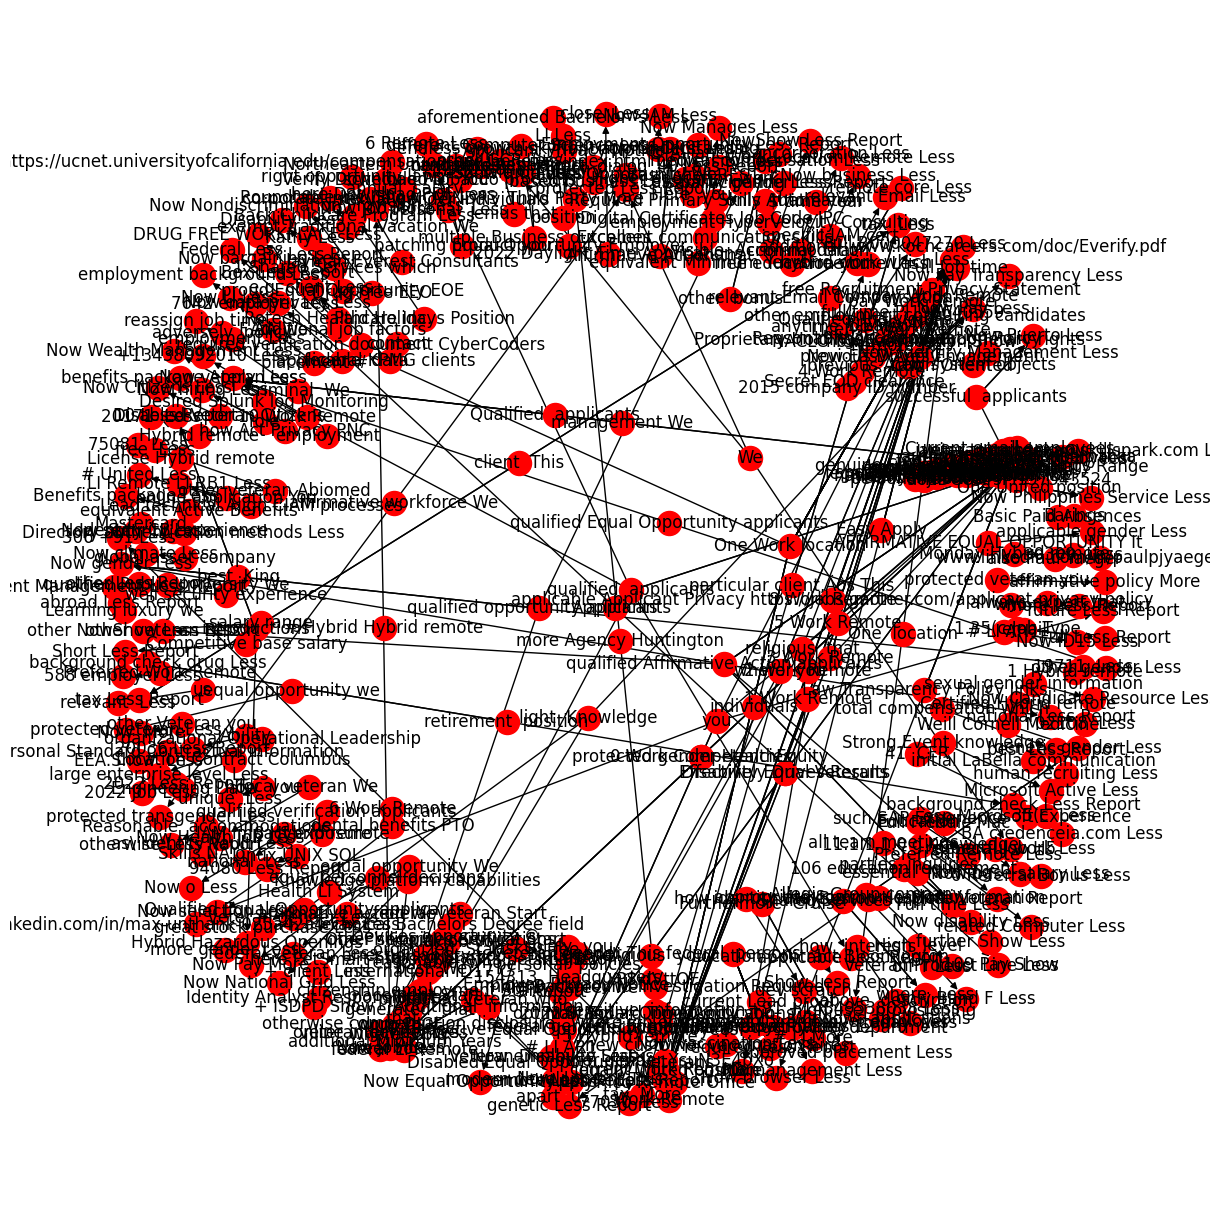

In [38]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

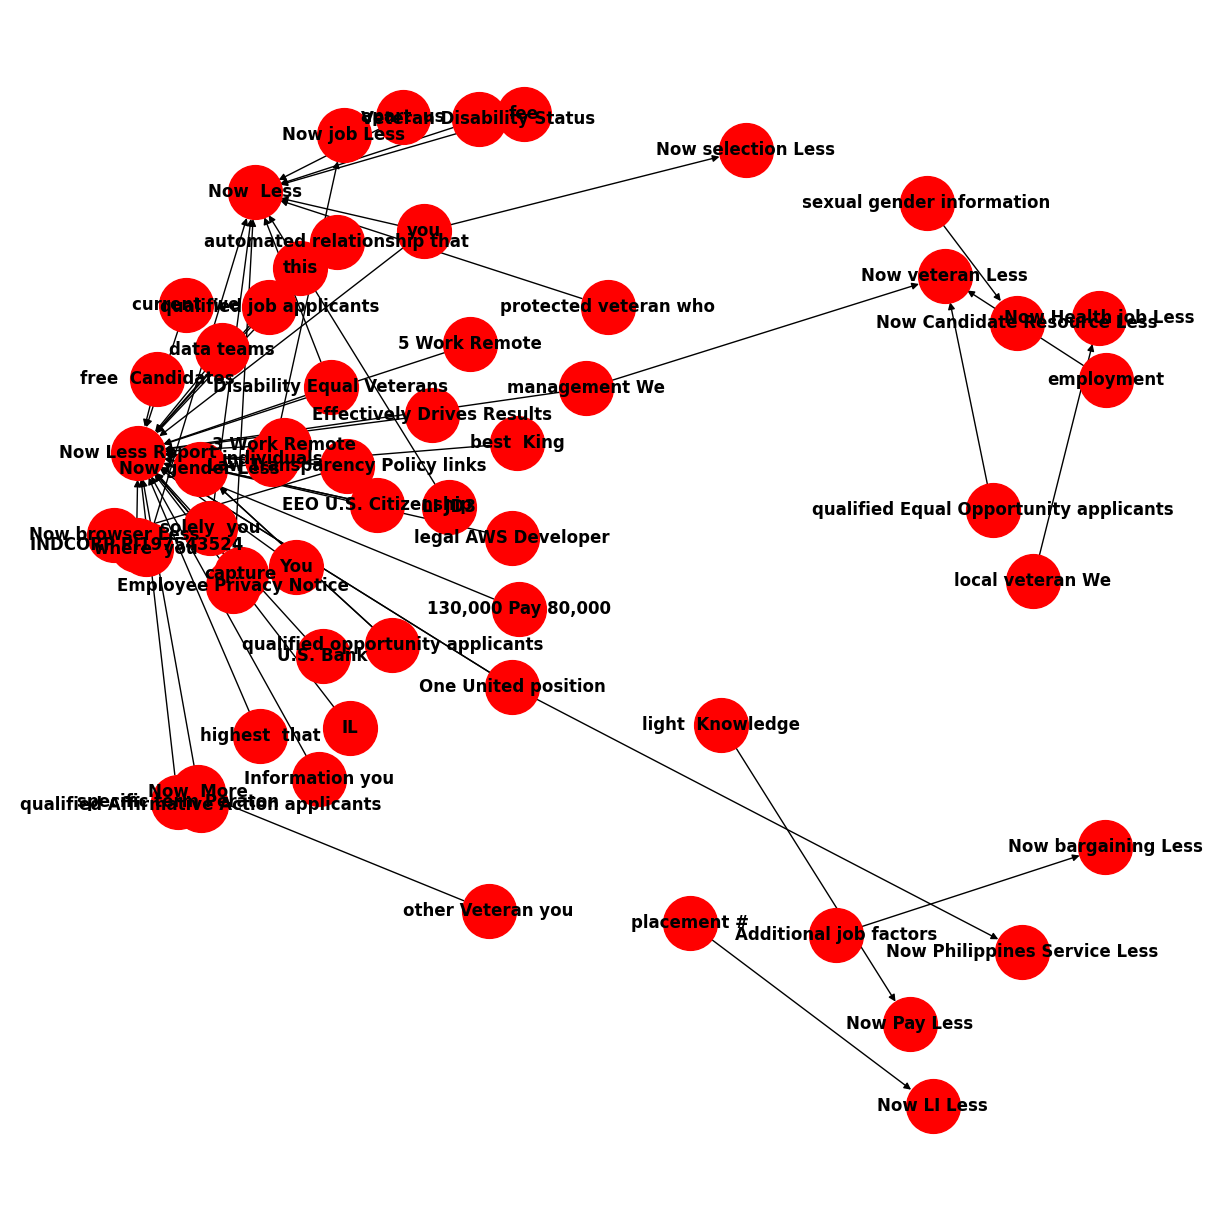

In [39]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="Apply"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()